# Customer Value and Churn - Online Retail

## What this notebook does

This notebook takes cleaned invoice line data from an online retailer and builds a customer level view of value and churn.

**Input data**

- `ltv_clean.csv`

Each row is a single invoice line with:

- `invoice_no` - invoice number
- `stock_code` - product code
- `description` - product description
- `quantity` - units sold
- `unit_price` - price per unit
- `invoice_date` - invoice timestamp
- `customer_id` - customer identifier
- `country` - customer country

The goal is to:

- roll transactions up to one row per customer  
- calculate how much value each customer has generated in the observed period  
- label customers as active or churned based on recency  
- group customers into value segments to compare churn and revenue

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#set display options
plt.rcParams["figure.figsize"] = (8, 5)

#load cleaned transactions
tx_df = pd.read_csv("ltv_clean.csv", parse_dates=["invoice_date"])

print("Transactions shape:", tx_df.shape)
print("\nTransactions dtypes:\n", tx_df.dtypes)

Transactions shape: (400916, 8)

Transactions dtypes:
 invoice_no               int64
stock_code              object
description             object
quantity                 int64
unit_price             float64
country                 object
customer_id              int64
invoice_date    datetime64[ns]
dtype: object


In [ ]:
#add revenue per invoice line
tx_df["revenue"] = tx_df["quantity"] * tx_df["unit_price"]

#build order level table
order_df = (
    tx_df
    .groupby(["customer_id", "invoice_no"])
    .agg(
        order_date=("invoice_date", "max"),
        order_revenue=("revenue", "sum")
    )
    .reset_index()
)

print("\nOrders shape:", order_df.shape)


Orders shape: (19213, 4)


In [4]:
#build customer level summary
customer_df = (
    order_df
    .groupby("customer_id")
    .agg(
        first_order_date=("order_date", "min"),
        last_order_date=("order_date", "max"),
        n_orders=("invoice_no", "nunique"),
        total_revenue=("order_revenue", "sum"),
        avg_order_value=("order_revenue", "mean")
    )
    .reset_index()
)

#ensure customer_id is integer
customer_df["customer_id"] = customer_df["customer_id"].astype("int64")

#add tenure and recency features
analysis_date = order_df["order_date"].max()

customer_df["tenure_days"] = (customer_df["last_order_date"] - customer_df["first_order_date"]).dt.days
customer_df["days_since_last_order"] = (analysis_date - customer_df["last_order_date"]).dt.days

print("\nCustomer summary shape:", customer_df.shape)
print("\nCustomer summary preview:\n", customer_df.head())


Customer summary shape: (4312, 8)

Customer summary preview:
    customer_id    first_order_date     last_order_date  n_orders  \
0        12346 2009-12-14 08:34:00 2010-06-28 13:53:00        11   
1        12347 2010-10-31 14:20:00 2010-12-07 14:57:00         2   
2        12348 2010-09-27 14:59:00 2010-09-27 14:59:00         1   
3        12349 2010-04-29 13:20:00 2010-10-28 08:23:00         3   
4        12351 2010-11-29 15:23:00 2010-11-29 15:23:00         1   

   total_revenue  avg_order_value  tenure_days  days_since_last_order  
0         372.86        33.896364          196                    164  
1        1323.32       661.660000           37                      2  
2         222.16       222.160000            0                     73  
3        2671.14       890.380000          181                     42  
4         300.93       300.930000            0                     10  


In [ ]:
#define churn
churn_threshold_days = 180  #can be adjusted if needed
customer_df["churn_flag"] = (customer_df["days_since_last_order"] > churn_threshold_days).astype(int)

churn_counts = customer_df["churn_flag"].value_counts(dropna=False)
churn_rates = customer_df["churn_flag"].value_counts(normalize=True, dropna=False)

print("\nChurn counts (0 active, 1 churned):\n", churn_counts)
print("\nChurn rates:\n", churn_rates)


Churn counts (0 active, 1 churned):
 churn_flag
0    3487
1     825
Name: count, dtype: int64

Churn rates:
 churn_flag
0    0.808673
1    0.191327
Name: proportion, dtype: float64


In [ ]:
#simple CLTV metric
customer_df["cltv"] = customer_df["total_revenue"]

print("\nCLTV summary:\n", customer_df["cltv"].describe())


CLTV summary:
 count      4312.000000
mean       2040.406712
std        8911.755977
min           2.950000
25%         307.187500
50%         701.615000
75%        1714.932500
max      349164.350000
Name: cltv, dtype: float64



Segment summary:
   cltv_segment  customers  total_revenue     avg_cltv  churn_rate
1          Low       1423     309814.991   217.719600    0.375966
2       Medium       1423    1037370.572   729.002510    0.158819
0         High       1466    7451048.181  5082.570383    0.043656


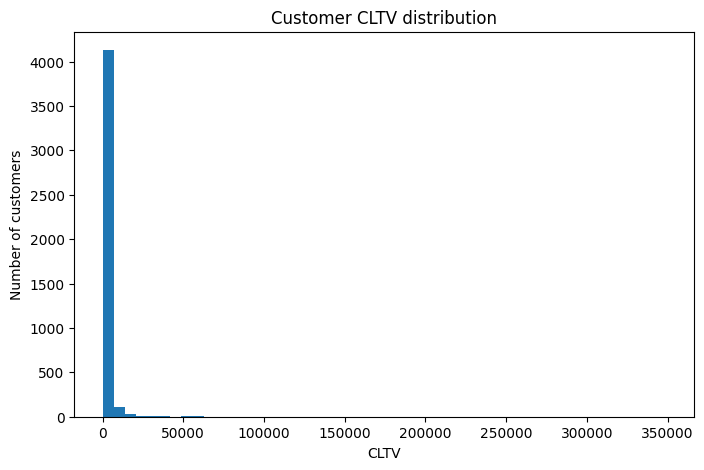

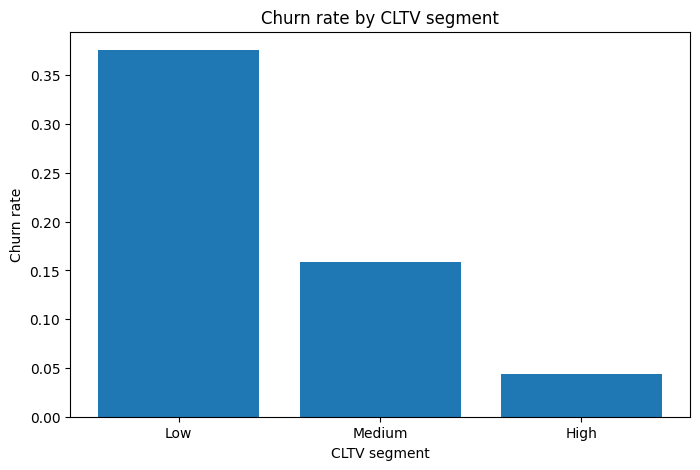

In [ ]:
#CLTV segments and summaries, compute segment thresholds
q1 = customer_df["cltv"].quantile(0.33)
q2 = customer_df["cltv"].quantile(0.66)

def cltv_segment(x):
    if x <= q1:
        return "Low"
    elif x <= q2:
        return "Medium"
    else:
        return "High"

customer_df["cltv_segment"] = customer_df["cltv"].apply(cltv_segment)

segment_summary = (
    customer_df
    .groupby("cltv_segment")
    .agg(
        customers=("customer_id", "nunique"),
        total_revenue=("total_revenue", "sum"),
        avg_cltv=("cltv", "mean"),
        churn_rate=("churn_flag", "mean")
    )
    .reset_index()
    .sort_values("avg_cltv")
)

print("\nSegment summary:\n", segment_summary)

#CLTV distribution plot
plt.hist(customer_df["cltv"], bins=50)
plt.xlabel("CLTV")
plt.ylabel("Number of customers")
plt.title("Customer CLTV distribution")
plt.show()

#churn rate by CLTV segment
plt.bar(segment_summary["cltv_segment"], segment_summary["churn_rate"])
plt.xlabel("CLTV segment")
plt.ylabel("Churn rate")
plt.title("Churn rate by CLTV segment")
plt.show()

In [ ]:
#export customer level table for reuse
customer_df.to_csv("ltv_results.csv", index=False)
print("\nExported customer level table to ltv_results.csv")


Exported customer level table to customer_value_churn.csv


## Summary

After running this notebook we have:

- a customer level table `customer_value_churn.csv` with CLTV, churn flag, and basic behavior metrics  
- CLTV segments that show how churn and revenue differ across low, medium, and high value customers  

This table is ready for use in dashboards or as input to more advanced models.